In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
tf.test.gpu_device_name()
!/opt/bin/nvidia-smi

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.chdir('/content/drive/Shareddrives/Part IV 700 - Siwei Yang and Sky Nguyen/Colab/')
print('Current Working Directory ' , os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: /opt/bin/nvidia-smi: No such file or directory
Current Working Directory  /content/drive/Shareddrives/Part IV 700 - Siwei Yang and Sky Nguyen/Colab


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

In [ ]:
def dispCCC(df):
    # Get CCC
    cccVal = ccc(df.loc[:,df.columns[0]], df.loc[:,df.columns[1]])
    cccVal = np.array2string(cccVal, precision=4)
    print('\t\t'+df.columns[0]+'\t\t'+df.columns[1])
    print(df.columns[0]+'\t\t'+'1.0000'+'\t\t'+cccVal)
    print(df.columns[1]+'\t'+cccVal+'\t\t'+'1.0000')

## Use existing submission result


In [ ]:
submissionPath = 'outputFile/models/[202109211552]aRsModel/es2jSubmission.csv'
submission = pd.read_csv(submissionPath)

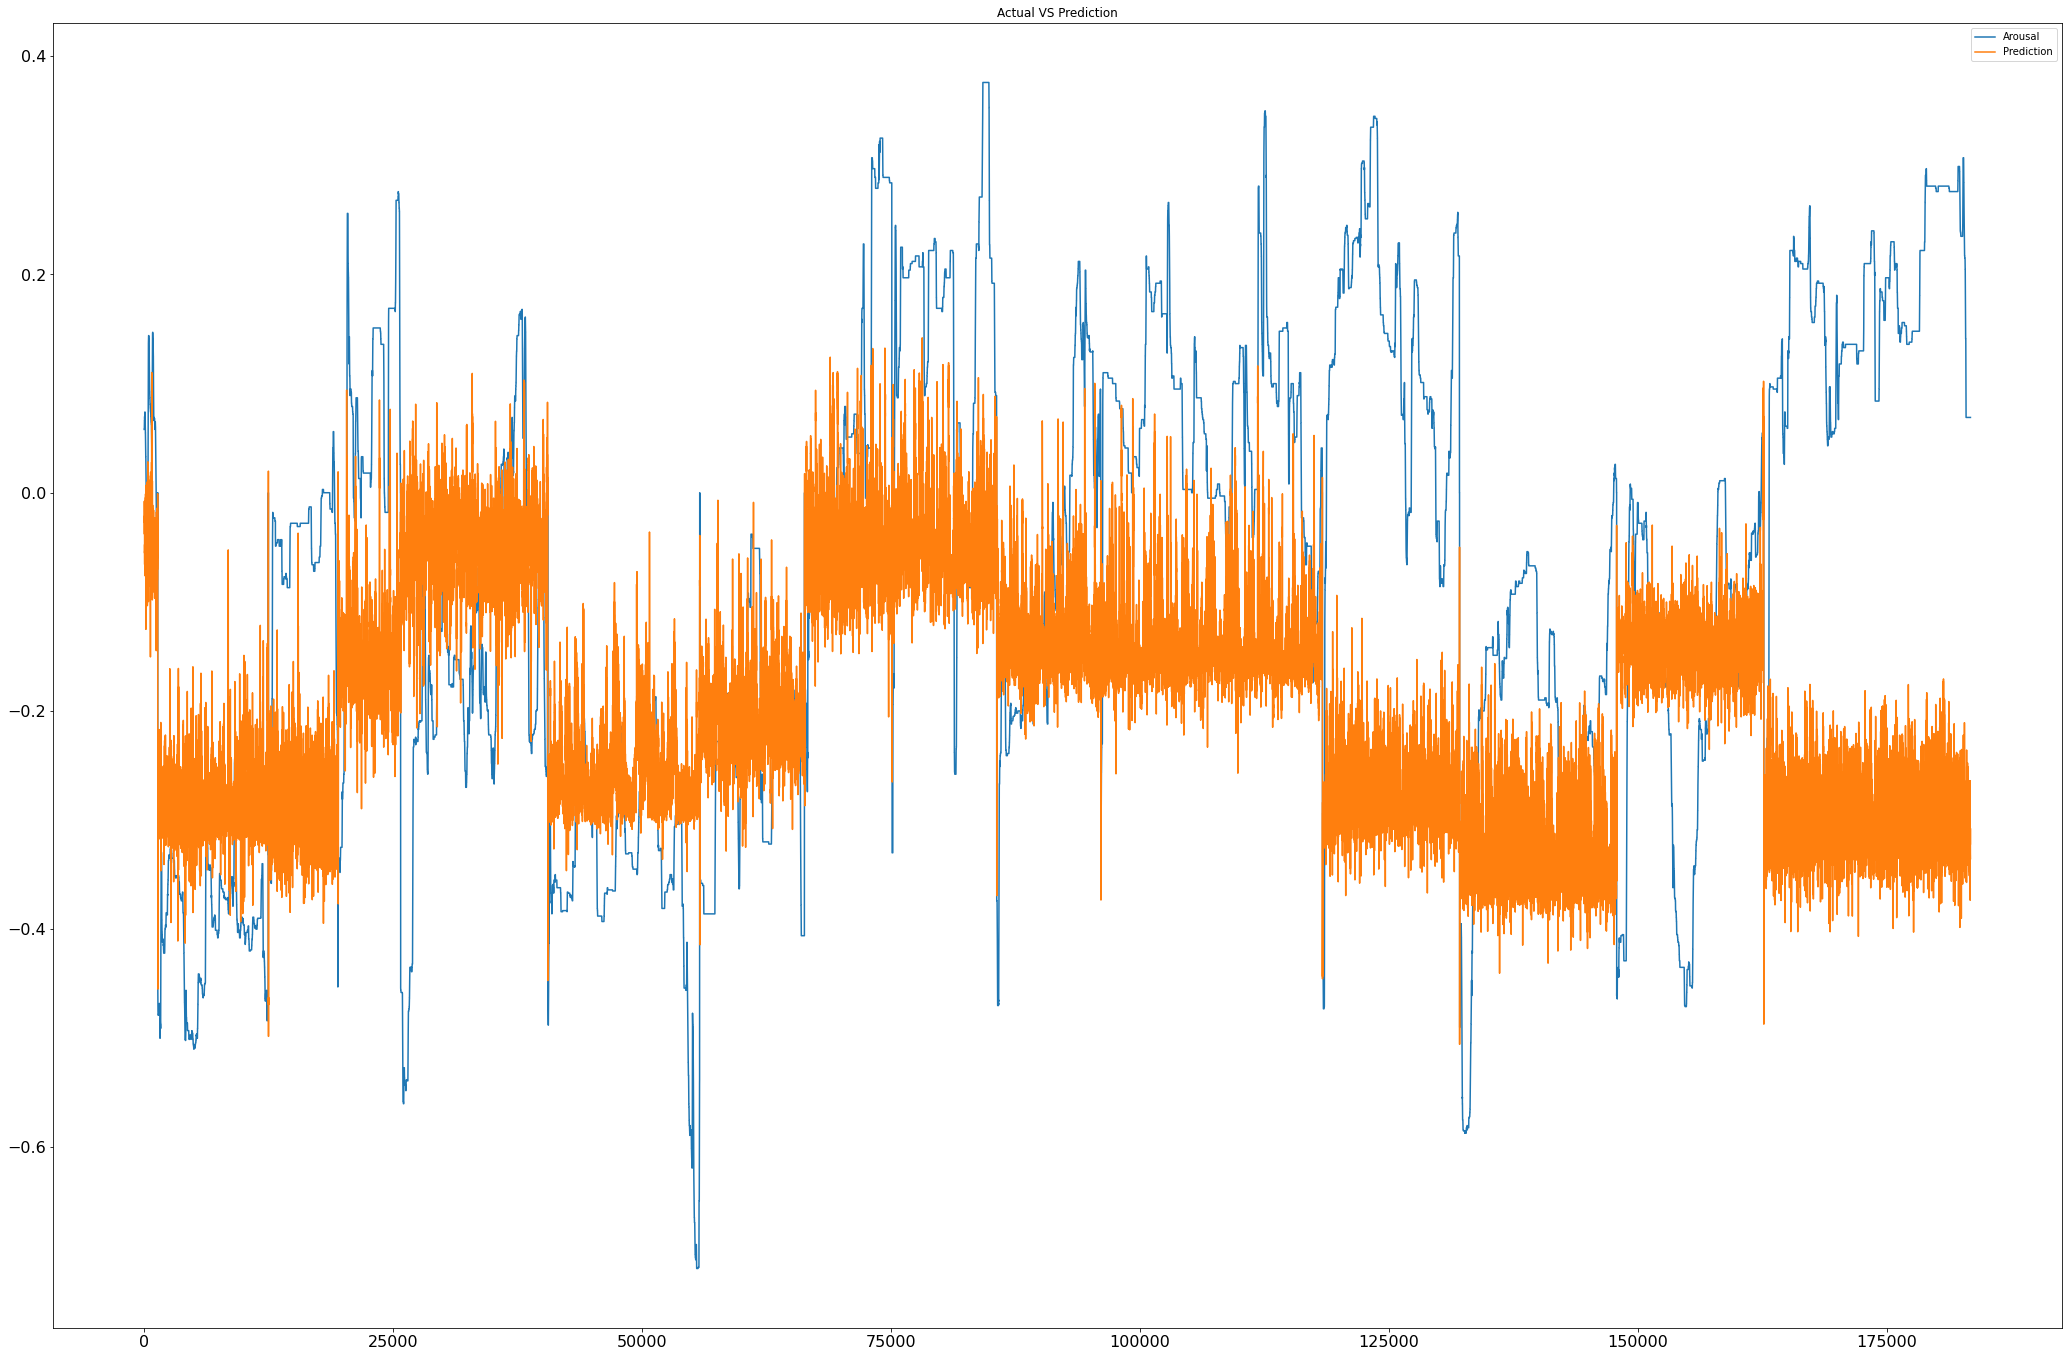

In [ ]:
submission.loc[1:, ['Arousal', 'Prediction']][:].plot(figsize=(36, 24), title='Actual VS Prediction', fontsize=16)
plt.show()

Pearson Correlation
             Arousal  Prediction
Arousal     1.000000    0.166034
Prediction  0.166034    1.000000

CCC
		Arousal		Prediction
Arousal		1.0000		0.1019
Prediction	0.1019		1.0000


<Figure size 1728x1728 with 0 Axes>

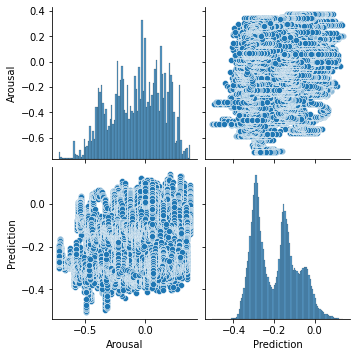

In [ ]:
correlation = submission.corr(method='pearson')
print('Pearson Correlation')
print(correlation)
print()
print('CCC')
dispCCC(submission)
d0 = submission[['Arousal', 'Prediction']]
plt.ioff()
fig = plt.figure(figsize=[24, 24])
fig.suptitle('Actual Prediction Correlation', fontsize=16)
sns.pairplot(d0, kind='scatter')
plt.show()

## Use the model to predict


In [ ]:
modelPath = 'outputFile/models/bestWeight.hdf5'

In [ ]:
# prepare data for lstms
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Define scaler, feature number and number of step looking back
scale_range = (0, 1)
scaler = MinMaxScaler(feature_range=scale_range)
n_steps = 24  # exclude the current step
n_features = 7

transformTarget = True

In [ ]:
usingJL = False

if usingJL:
    testingDataset = pd.read_csv('inputFile/modelInput/oneSecond/jlco0000st.csv')
else:
    testingDataset = pd.read_csv('inputFile/modelInput/oneSecond/allFileCombineP.csv')
    print(testingDataset.shape)
    testingDataset = testingDataset[-1200:]

targetOfTestingDataset = testingDataset['Arousal'][n_steps:]
testingDataset = testingDataset[['RMS', 'F0', 'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5']]
print(testingDataset.head(5))

# load and build testing dataset
values = testingDataset.values
# normalize features
testingScaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(testingScaled, n_steps, 1)
print(reframed.shape)
values = reframed.values
test = values

test_X = test
test_y = targetOfTestingDataset

# reshape input to be 3D [samples, timesteps (n_steps before + 1 current step), features]
test_X = test_X.reshape((test_X.shape[0], n_steps + 1, n_features))

(36895, 11)
         RMS         F0     MFCC1      MFCC2     MFCC3      MFCC4      MFCC5
0   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
1   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
2   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
3   0.000000   0.000000    0.0000   0.000000   0.00000   0.000000   0.000000
4 -60.325294  55.160935 -533.2911  48.249077  14.81778  20.503918  17.566671
(36871, 175)


In [ ]:
# Load the model
loadOptions = tf.saved_model.LoadOptions(
    allow_partial_checkpoint=False, experimental_io_device=None,
    experimental_skip_checkpoint=False
)
model = keras.models.load_model(filepath=modelPath, options=loadOptions, compile=False)

In [ ]:
# transforming targets
if transformTarget:
    # fit inverse scaler
    scaler.fit_transform(np.array(targetOfTestingDataset).reshape(-1, 1))

In [ ]:
# make a prediction
if transformTarget:
    inv_yPredict = model.predict(test_X)
    # inv transform the predicted value
    yPredict = scaler.inverse_transform(inv_yPredict.reshape(-1, 1))
    yPredict = yPredict[:, 0]
else:
    yPredict = model.predict(test_X)

# actual value
yActual = test_y
# calculate RMSE
rmse = np.sqrt(mean_squared_error(yActual, yPredict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.571


In [ ]:
r2_score(yActual, yPredict)

-5.909712962951457

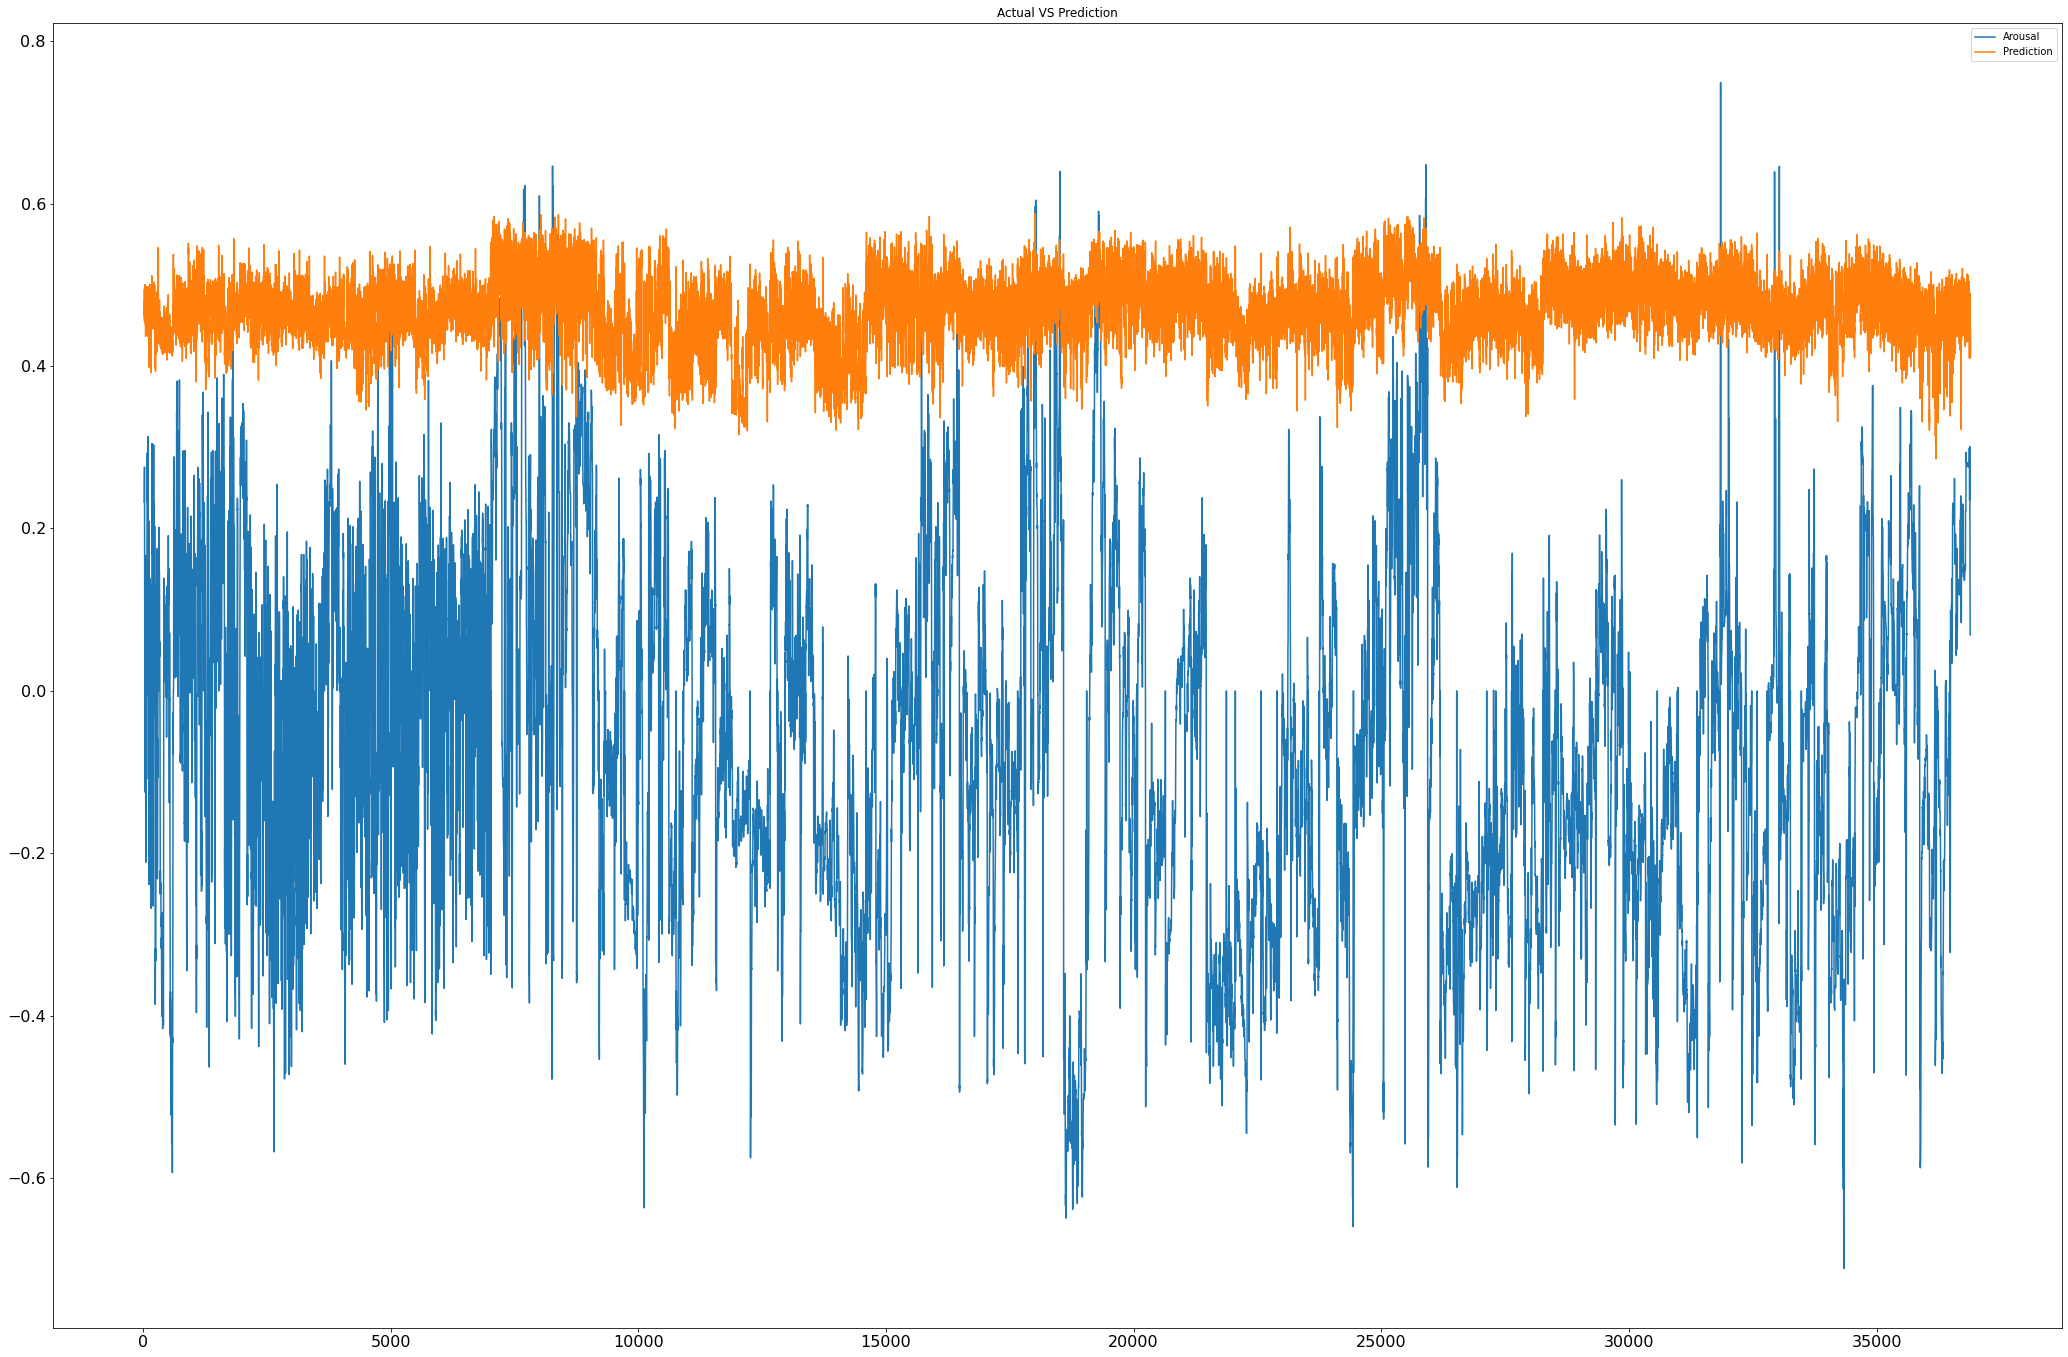

In [ ]:
pred_test_list = [i for i in yPredict]
actualVsPrediction = pd.DataFrame({'Arousal': yActual, 'Prediction': pred_test_list})
actualVsPrediction.loc[1:, ['Arousal', 'Prediction']].plot(figsize=(36, 24), title='Actual VS Prediction', fontsize=16)
plt.show()

Pearson Correlation
             Arousal  Prediction
Arousal     1.000000    0.585017
Prediction  0.585017    1.000000

CCC
		Arousal		Prediction
Arousal		1.0000		0.0435
Prediction	0.0435		1.0000


<Figure size 1728x1728 with 0 Axes>

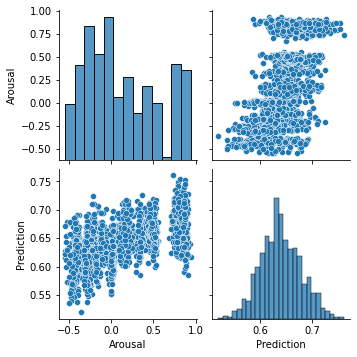

In [ ]:
correlation = actualVsPrediction.corr(method='pearson')
print('Pearson Correlation')
print(correlation)
print()
print('CCC')
dispCCC(actualVsPrediction)
d0 = actualVsPrediction[['Arousal', 'Prediction']]
plt.ioff()
fig = plt.figure(figsize=[24, 24])
fig.suptitle('Actual Prediction Correlation', fontsize=16)
sns.pairplot(d0, kind='scatter')
plt.show()